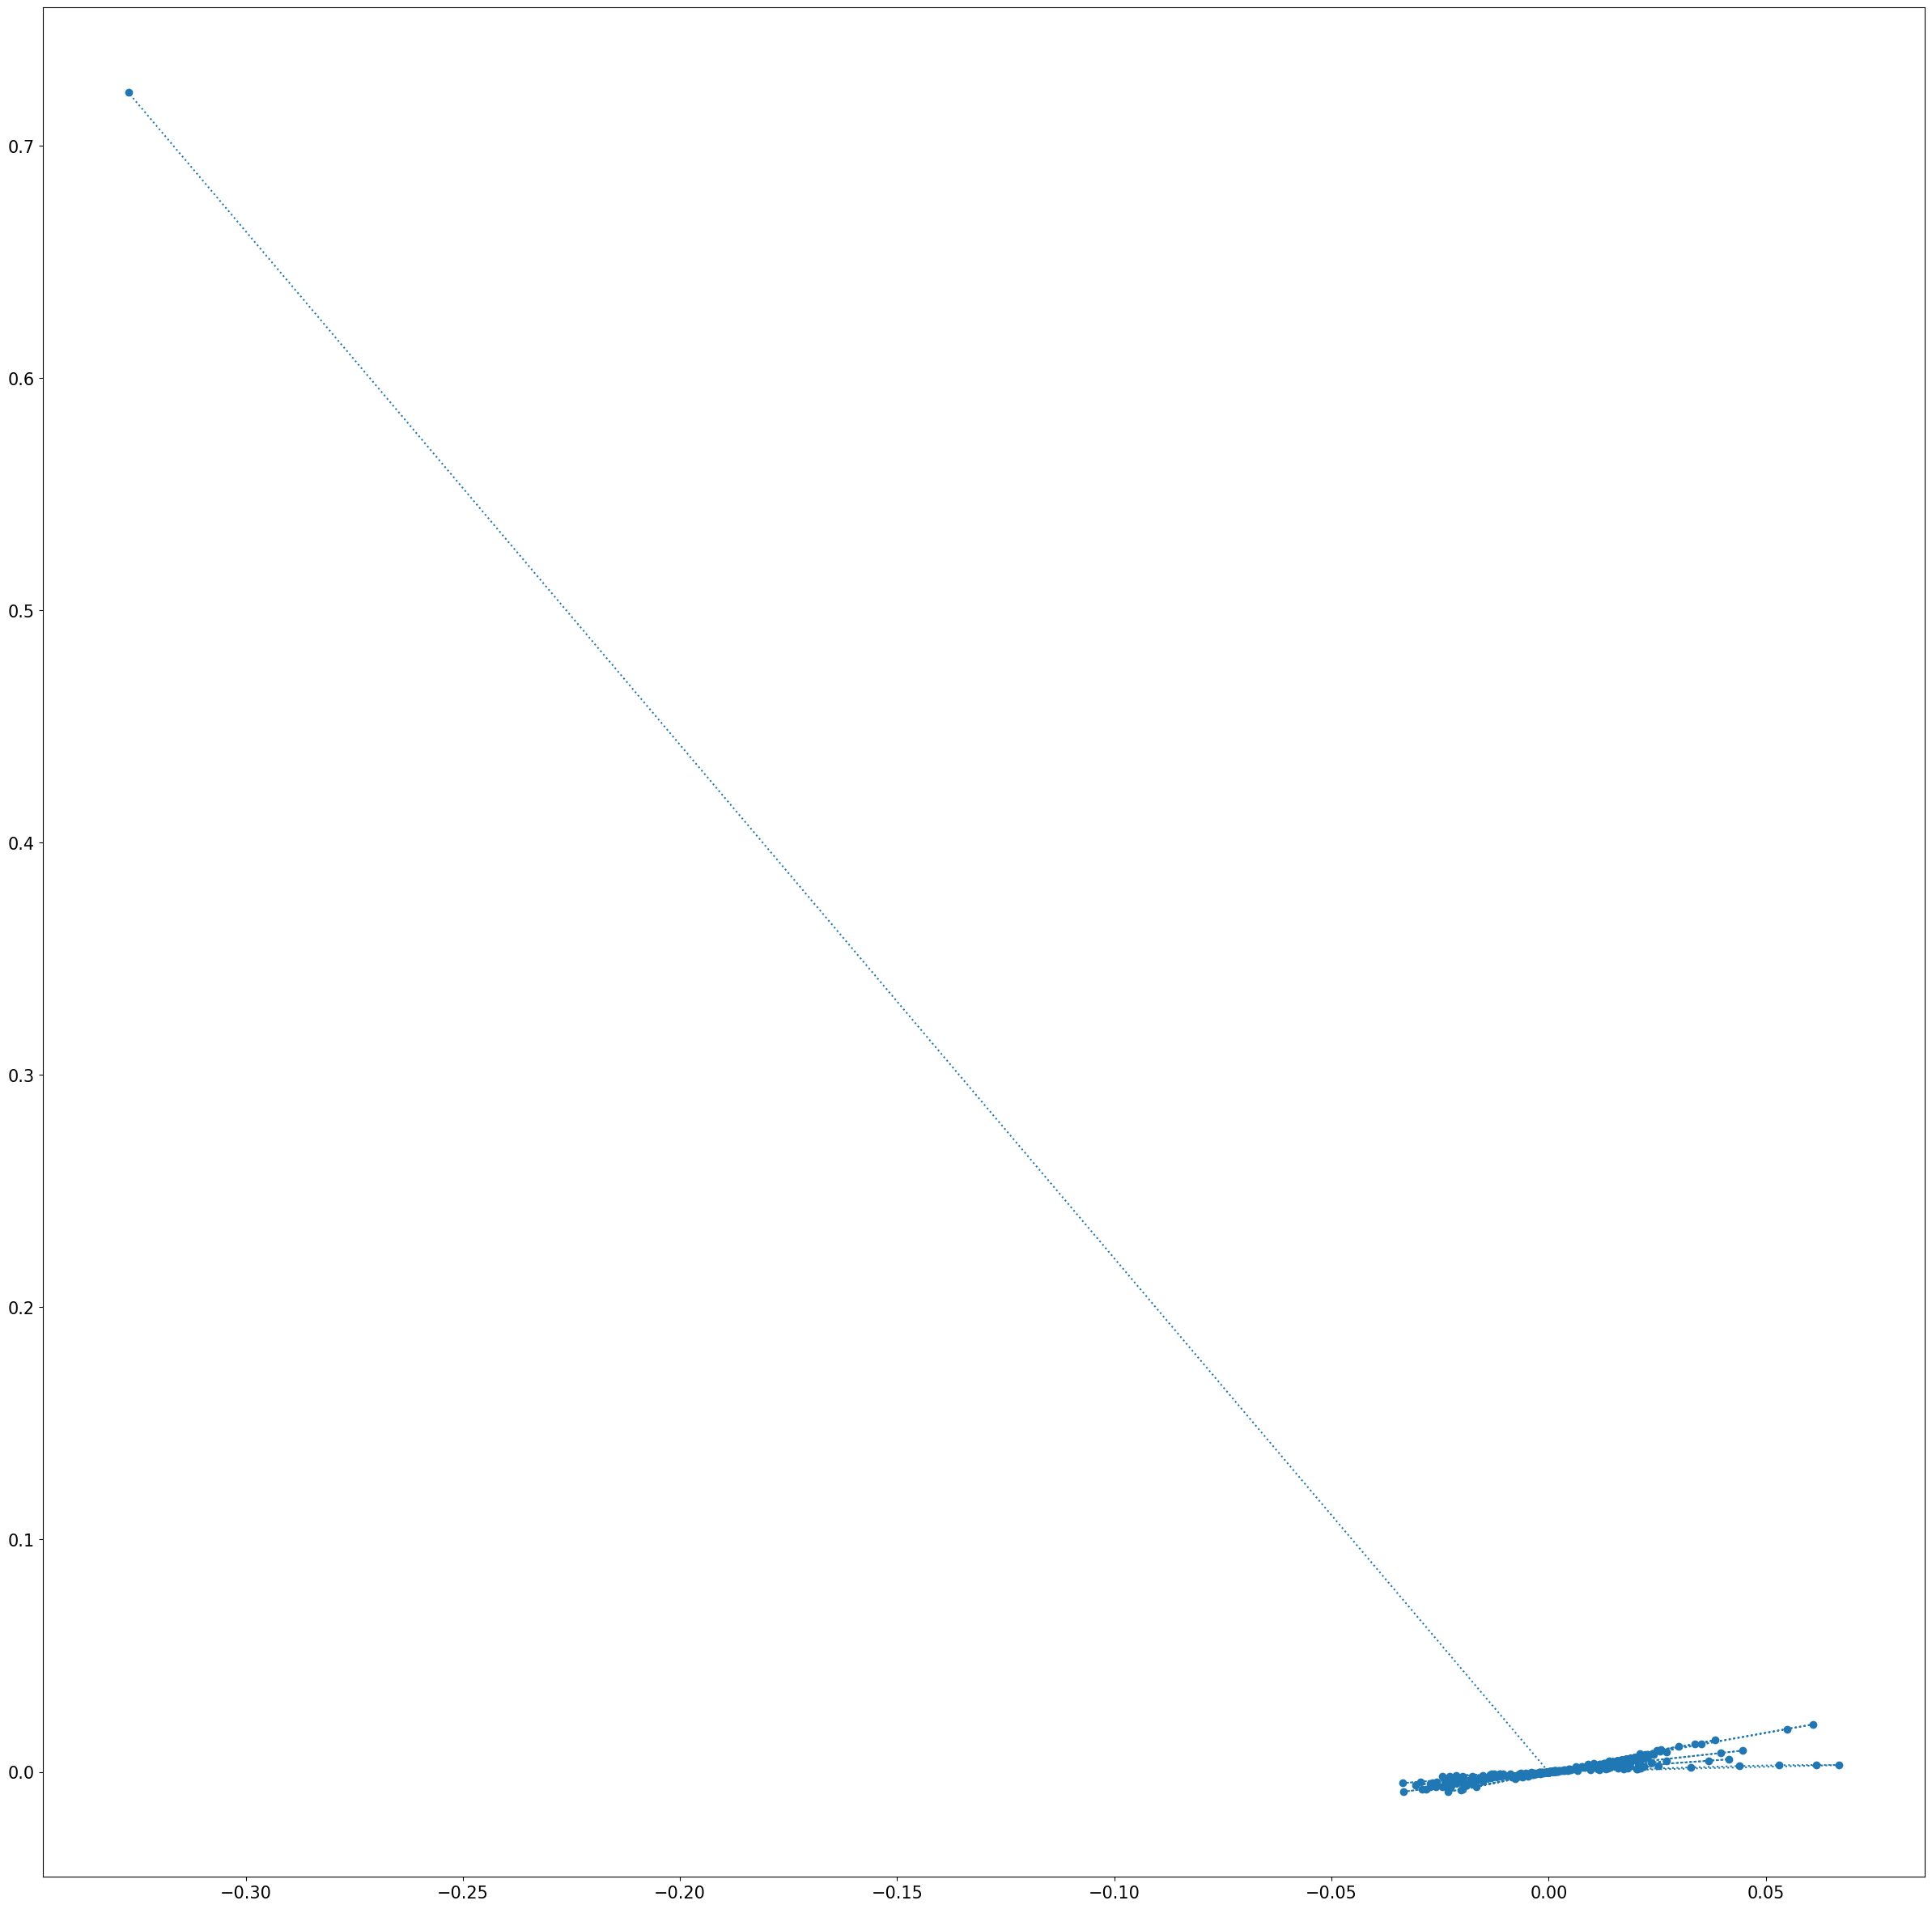

In [187]:
#r = np.linspace(0, 10, 1000)
#lamb = np.linspace(0, 2 * np.pi, 1000) #-3/2 * np.pi
R_E = 0.1
hinit = 0.1
xlim = -2, 20
Yinit   = np.array([1e-5, 0]) #4

#constant
B_0 = 3.12 * 1e-5 #T

def F_B(t, Y):
    [r, lamb] = Y
    R = r / R_E
    B_r = -2 * (B_0 / R**3) * np.sin(lamb)
    B_lambda = B_0 / 3 * np.cos(lamb)
    dY = [(B_r) / (B_r**2 + B_lambda**2)**0.5, (B_lambda) / (B_r**2 + B_lambda**2)**0.5]
    return np.array(dY) # (B_r, B_lambda)
    
def pol2cart(rho, phi):
    x = rho * np.cos(phi)
    y = rho * np.sin(phi)
    return (x, y)
t, Y, h = embedded_rk4_ode(F_B, Yinit, hinit, xlim, abstol=1e-8, reltol=1e-8,
                           hminmax=(1e-8, 10), max_iterations=100000)
x, y = map(np.array, zip(*Y))

#a, b = zip(*sol)
#print(a, b)

# drawing
plt.figure(figsize=[30, 30])
plt.plot(pol2cart(x, y)[0], pol2cart(x, y)[1],':o')
#plt.plot(pol2cart(x,y)[0], pol2cart(x,y)[1], '-b')
plt.savefig("game.jpg")

In [3]:
def embedded_rk4_ode(f, y0, h0, xlim, abstol=0, reltol=1e-7, hminmax=(1e-30, 1e30),
                     max_iterations=2**30, should_trim_endpoint=True):
    """Approximate the solution of y' = f(y, x) by embedded 4th-order Runge-Kutta method.
    
    :param f:
        Right-hand side of the differential equation y' = f(y, x).
    :param y0:
        Initial value y0 = y(x0) where x0 is the first element of list xlim.
    :param h0:
        Initial stepsize.
    :param xlim:
        A pair of values denoting the integral limit.
    :param abstol=float:
        Absolute error tolerence needed.
    :param reltol=float:
        Relative error tolerence needed.
    :param hminmax=(hmin, hmax):
        The minimum and maximum stepsizes in which the next stepsize must lie.
    :param max_iterations=integer:
        The maximum number of iterations allowed.
    :param should_trim_endpoint=boolean:
        If True, modify the last approximation to the value at x = xlim[1].
        
    :return:
    Returns x values, y values, and step sizes.
    """

    x0, xf = xlim

    # table
    a2 , a3 , a4 , a5 , a6  = 1/5, 3/10, 3/5, 1, 7/8
    b21, b31, b41, b51, b61 = 1/5, 3/40, 3/10, -11/54, 1631/55296
    b32, b42, b52, b62      = 9/40, -9/10, 5/2, 175/512
    b43, b53, b63           = 6/5, -70/27, 575/13824
    b54, b64                = 35/27, 44275/110592
    b65                     = 253/4096
    #
    c1, c2, c3, c4, c5, c6  = 37/378, 0, 250/621, 125/594, 0, 512/1771
    d1, d2, d3              = c1 - 2825/27648, c2 - 0, c3 - 18575/48384
    d4, d5, d6              = c4 - 13525/55296, c5 - 277/14336, c6 - 1/4

    def single_step(x, y, h):
        k1 = h*f(x       , y)
        k2 = h*f(x + a2*h, y + b21*k1)
        k3 = h*f(x + a3*h, y + b31*k1 + b32*k2)
        k4 = h*f(x + a4*h, y + b41*k1 + b42*k2 + b43*k3)
        k5 = h*f(x + a5*h, y + b51*k1 + b52*k2 + b53*k3 + b54*k4)
        k6 = h*f(x + a6*h, y + b61*k1 + b62*k2 + b63*k3 + b64*k4 + b65*k5)
        
        # approximation of y
        y = y + c1*k1 + c2*k2 + c3*k3 + c4*k4 + c5*k5 + c6*k6
        x = x + h

        # error estimate
        delta = d1*k1 + d2*k2 + d3*k3 + d4*k4 + d5*k5 + d6*k6
        
        y_tmp = abs(y) + abs(h*k1) # this is to prevent y ≈ 0
        desired = abs(abstol) + abs(y_tmp*reltol)
        rel_err = delta / desired
        if type(rel_err) is not float:                                  # in case of ndarray,
            rel_err = np.sqrt(sum(rel_err.flatten()**2) / len(rel_err)) # take square norm

        # next step size
        h = h / max(abs(rel_err)**0.2, 1e-2)    # limit the max stepsize increase
        h = min(max(h, hminmax[0]), hminmax[1]) # finally, clamp stepsize
    
        return x, y, h
    
    # loop
    xs = [x0]
    ys = [y0]
    hs = [h0]
    i  = 0
    while i < max_iterations and x0 < xf:
        x0, y0, h0 = single_step(x0, y0, h0)
        xs.append(x0)
        ys.append(y0)
        hs.append(h0)
        i += 1
        
    if should_trim_endpoint:
        xs[-1], ys[-1], _ = single_step(xs[-2], ys[-2], xf - xs[-2])
    
    return xs, ys, hs

In [4]:
import numpy as np
from matplotlib import pyplot as plt
plt.rcParams.update({'font.size': 15})
#%config InlineBackend.figure_format='retina'